# This script demonstrates how to optimize a variational autoencoder with talos

In [1]:
# VAE
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()

# DL
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.optimizers import Adam, Nadam, RMSprop
from keras.datasets import mnist

# Math
import numpy as np
from scipy.stats import norm

# Plot
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import astetik
%matplotlib inline

# Hyperparameter search
from talos.model.normalizers import lr_normalizer
import talos as ta

Using TensorFlow backend.


python version:  3.5.2
keras version: 2.2.4
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
# Define the network and parameter structure

# p = {'lr': [10., 1, 0.1],
#      'intermediate_dim': [64, 128],
#      'activation':['elu'],
#      'batch_size': [64, 128],
#      'epochs': [20, 40],
#      'optimizer': [Adam, Nadam, RMSprop],
#      'beta': [1.0],
#      'reconstruction_loss_metrics': [ReconstructionLoss.MSE],
#      'z_dim': [2, 4]}

p = {'lr': [1],
     'intermediate_dim': [64, 128, 256],
     'activation':['relu', 'elu'],
     'batch_size': [1024, 2048],
     'epochs': [10, 20],
     'optimizer': [Adam, RMSprop],
     'beta': [0.01, 1.0],
     'reconstruction_loss_metrics': [ReconstructionLoss.MSE],
     'z_dim': [2]}
# p = {'lr': [1],
#      'intermediate_dim': [64, 128, 256],
#      'activation':['elu'],
#      'batch_size': [1024],
#      'epochs': [2],
#      'optimizer': [Adam],
#      'beta': [1.0],
#      'reconstruction_loss_metrics': [ReconstructionLoss.MSE],
#      'z_dim': [2]}

img_rows, img_cols, img_chns = 28, 28, 1
original_dim = img_rows * img_cols * img_chns
def vae_model(x_train, y_train, x_val, y_val, params):
    vae_tools.sampling.set_seed(0)
    encoder = [[
        Input(shape=(original_dim,)),
        Dense(params['intermediate_dim'], activation=params['activation']),
        Dense(int(params['intermediate_dim']/2), activation=params['activation'])
    ]]

    decoder = [[
        Dense(int(params['intermediate_dim']/2), activation=params['activation']), 
        Dense(params['intermediate_dim'], activation=params['activation']),
        Dense(original_dim, activation='sigmoid')
    ]]

    vae_obj = MmVae(params['z_dim'], encoder, decoder, [original_dim], params['beta'],
                    reconstruction_loss_metrics = [params['reconstruction_loss_metrics']], name='Vae')

    vae_model = vae_obj.get_model()
    vae_model.compile(optimizer=params['optimizer'](lr_normalizer(params['lr'], params['optimizer'])), loss=None)
    losses_cb = vae_tools.callbacks.Losses(data = x_val)
    out = vae_model.fit(x_train, shuffle=True, epochs=params['epochs'], batch_size=params['batch_size'], verbose = 0, callbacks=[losses_cb])
    
    # Append the losses to the history
    for k in losses_cb.history.keys():
        out.history['_'.join(k.split('/')[0].split('_')[:-1])] = losses_cb.history[k]
        
    # Append the latent space to the history
    encoder_input = [encoder[0][0]]
    encoder_model = vae_obj.get_encoder_mean(encoder_input)
    x_val_encoded = encoder_model.predict(x_val)
    out.history["encoded_test_samples"] = [x_val_encoded.copy()]
    out.history["encoded_test_labels"] = [y_val.copy()]
    return out, vae_model


In [4]:
# Parameter search
h = ta.Scan(x=x_train, y=y_train, params=p,
            model=vae_model,
            dataset_name='mnist',
            experiment_no='1',
            last_epoch_value=True,
            x_val=x_test, y_val=y_test)

100%|██████████| 96/96 [13:15<00:00,  7.73s/it]


In [5]:
# access the summary details
print(h.details)
# Create the report
r = ta.Reporting(h)
results = r.data

complete_time            03/12/19/22:46
experiment_name                 mnist_1
grid_downsample                       1
random_method          uniform_mersenne
reduce_loss                       False
reduction_interval                   50
reduction_method                   None
reduction_metric                val_acc
reduction_threshold                 0.2
reduction_window                     20
x_shape                    (60000, 784)
y_shape                        (60000,)
dtype: object


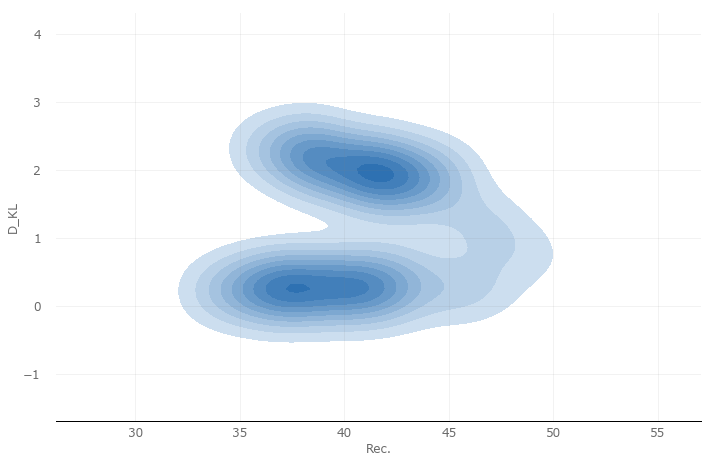

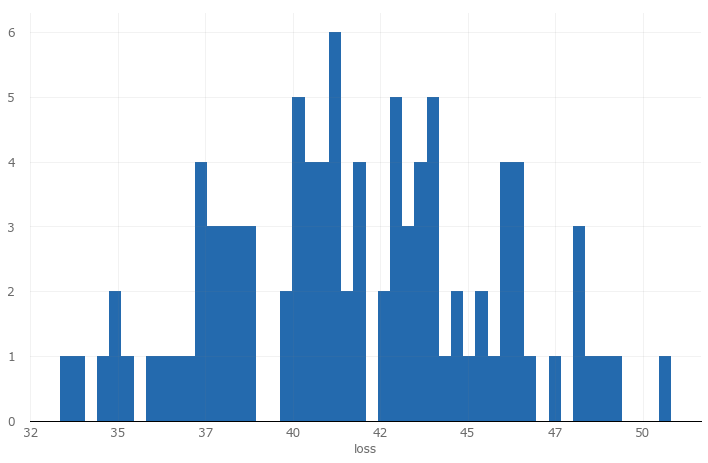

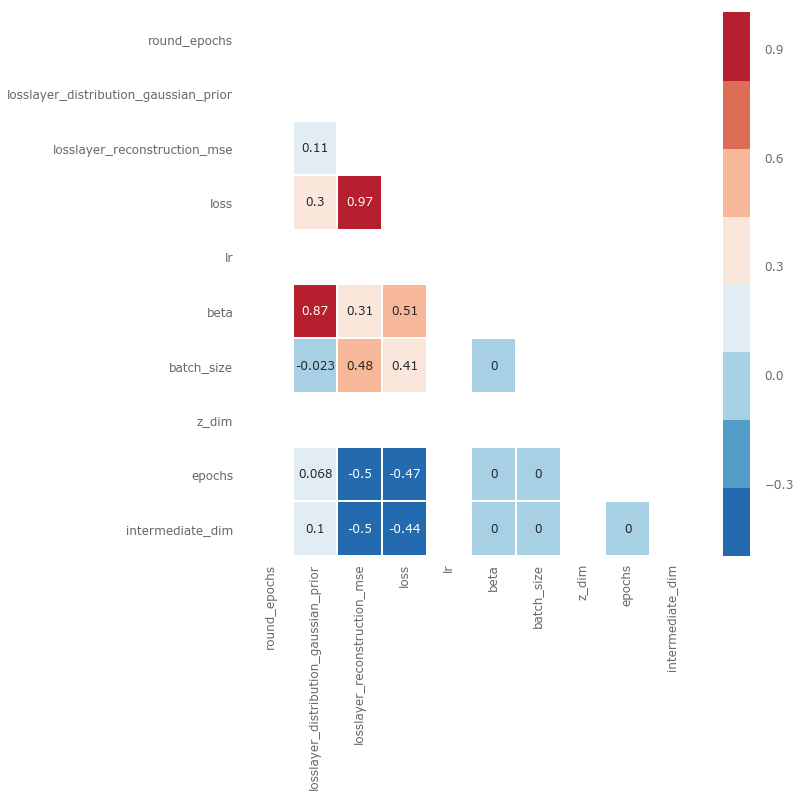

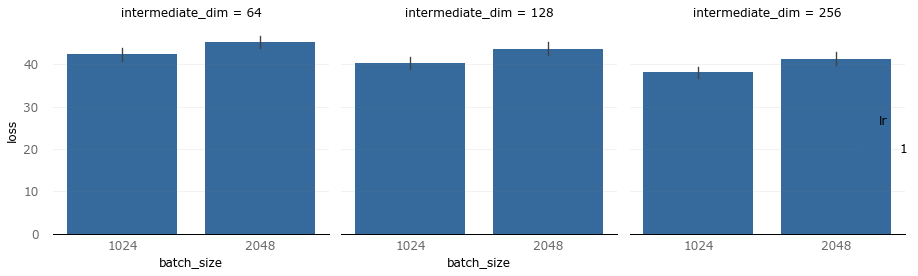

In [6]:
# a regression plot for two dimensions 
#astetik.regs(results, x='losslayer_reconstruction_mse', y='losslayer_distribution_gaussian_prior', x_label='Rec.', y_label='D_KL')
# up to two dimensional kernel density estimator
astetik.kde(results, x='losslayer_reconstruction_mse', y='losslayer_distribution_gaussian_prior', x_label='Rec.', y_label='D_KL')
# a simple histogram
astetik.hist(results, 'loss',bins=50, x_label='loss')
# correlation
astetik.corr(results.drop(["encoded_test_samples","encoded_test_labels","optimizer","reconstruction_loss_metrics"], axis=1), color_grades=5, style='astetik', annot=True)
# a four dimensional bar grid
astetik.bargrid(results, x='batch_size', y='loss', hue='lr', col='intermediate_dim',  col_wrap=3)

In [12]:
# Get the 5 best results according to the desired metric
def sort_params(r, metric='losslayer_reconstruction_mse', ascending=True):
    ''' Sort table 'r' (pandas DataFrame) wrt. 'metric'
    '''
    out = r.sort_values(metric, ascending=ascending) 
    try:
        out = out.drop(None, axis=1)
    finally:
        return out
out = sort_params(results, metric='losslayer_reconstruction_mse') # losslayer_distribution_gaussian_prior, losslayer_reconstruction_mse
best_of = 5
out.head(best_of).drop("encoded_test_samples", axis=1).drop("encoded_test_labels", axis=1).style

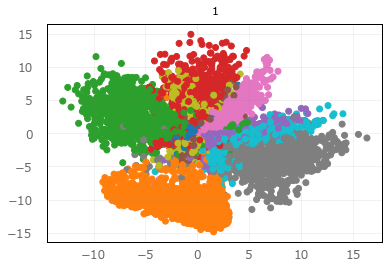

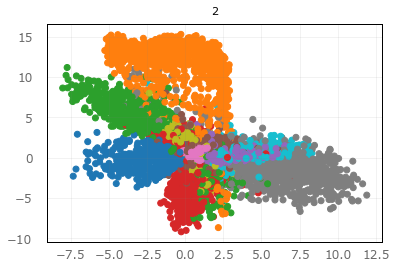

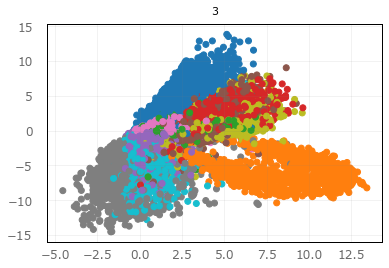

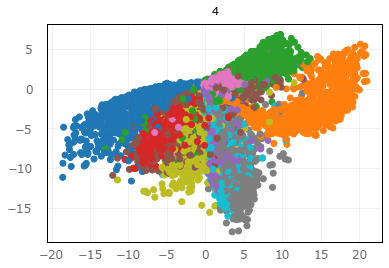

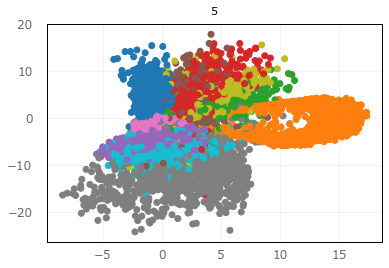

In [13]:
# Print the latent spaces of the results
for idx in range(min(len(out["encoded_test_samples"]),best_of)):
    plt.scatter(out["encoded_test_samples"].values[idx][:,0], out["encoded_test_samples"].values[idx][:,1], c=out["encoded_test_labels"].values[idx], cmap='tab10')
    plt.title(str(idx+1))
    plt.show()